In [106]:
import pandas as pd
import numpy as np
import sklearn as sk
import kagglehub
from kagglehub import KaggleDatasetAdapter
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

## Метрики
### Для задачи классификации
Хотя дисбаланс классов незначителен (≈55/45), задача носит медицинский характер, где ложноотрицательные предсказания могут иметь серьёзные последствия. Поэтому наряду с accuracy и ROC-AUC мы отслеживаем recall по положительному классу и F1-score как сбалансированную меру качества.
### Для задачи регрессии
Целевая переменная имеет квазинормальное распределение с накоплением значений на границах диапазона (0–5 и 95–10). Это указывает на важность корректного предсказания как слабых, так и сильных студентов. Поэтому мы используем RMSE, чувствительный к крупным ошибкам, MAE для интерпретируемости и коэффициент детерминации R² для оценки объяснённой доли дисперсии

# Классификация

Первые 5 строк и размер датасета

In [107]:
df = kagglehub.dataset_load(KaggleDatasetAdapter.PANDAS,
                                  "tan5577/heart-failure-dataset/versions/1",
                                  "heart.csv")
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [108]:
print(f"\nРазмер датасета: {df.shape}")
print("\nРаспределение целевой переменной:")
print(df['HeartDisease'].value_counts(normalize=True))


Размер датасета: (918, 12)

Распределение целевой переменной:
HeartDisease
1    0.553377
0    0.446623
Name: proportion, dtype: float64


Обработка категориальных и числовых признаков

In [109]:
numerical_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
binary_features = ['Sex', 'FastingBP', 'ExerciseAngina']
categorical_features = ['ChestPainType', 'RestingECG', 'ST_Slope']

df['Sex'] = df['Sex'].map({'M': 1, 'F': 0})
df['ExerciseAngina'] = df['ExerciseAngina'].map({'Y': 1, 'N': 0})

print("\nМинимальные значения числовых признаков:")
print(df[numerical_features].min())


Минимальные значения числовых признаков:
Age            28.0
RestingBP       0.0
Cholesterol     0.0
MaxHR          60.0
Oldpeak        -2.6
dtype: float64


Заменим пропущенные значения на медиану

In [110]:
df['Cholesterol'] = df['Cholesterol'].replace(0, df['Cholesterol'].median())
df['RestingBP'] = df['RestingBP'].replace(0, df['RestingBP'].median())

In [111]:
print("Количество NaN в каждом столбце после замены нулей:")
print(df.isnull().sum())

print("\nТипы данных:")
print(df.dtypes)

Количество NaN в каждом столбце после замены нулей:
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

Типы данных:
Age                 int64
Sex                 int64
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina      int64
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object


Убедимся, что числовые колонки — действительно числовые

In [112]:
for col in numerical_features:
    df[col] = pd.to_numeric(df[col], errors='coerce')

for col in numerical_features:
    df[col] = df[col].replace(0, np.nan)
    df[col] = df[col].fillna(df[col].median())

Функция для матрицы ошибок.

In [113]:
def conf_matrix(y_pred, y_test):
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Heart Disease', 'Heart Disease'],
                yticklabels=['No Heart Disease', 'Heart Disease'])
    plt.title('Confusion Matrix')
    plt.ylabel('Истинный класс')
    plt.xlabel('Предсказанный класс')
    plt.show()

Создание препроцессора

In [114]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ],
    remainder='passthrough'
)

Запуск модели от sklearn на обычном бейзлайне без улучшений.

Бейзлайн KNN (k=5):
Accuracy: 0.8533
ROC-AUC:  0.9194
F1-score: 0.8629
Recall:   0.8333


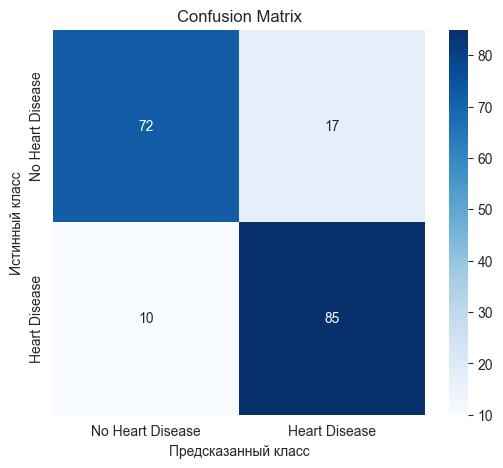

In [115]:
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

knn_baseline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=5))
])

knn_baseline.fit(X_train, y_train)
y_pred = knn_baseline.predict(X_test)

acc = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, knn_baseline.predict_proba(X_test)[:, 1])
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Бейзлайн KNN (k=5):")
print(f"Accuracy: {acc:.4f}")
print(f"ROC-AUC:  {roc_auc:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Recall:   {recall:.4f}")

conf_matrix(y_test, y_pred)

Модель показала очень хорошие результаты. При слабом дисбалансе accuracy достаточно информативна и показывает что модель классифицирует верно 85% пациентов. ROC-AUC > 0.9, модель отлично разделяет группы риска и не-риска. F1-score показывает, что баланс между precision и recall хороший. Recall - очень важная метрика в медицинских задачах, по ней видно, что только 17% больных будут пропущены (ложноотрицательные).

Перейдем к улучшению бейзлайна. Нашей задачей является найти оптимальное значение k, способ взвешивания вкладов соседей и лучшую метрику расстояния между точками. \
При малом k, модель чувствительна к шуму, а при большом - сглаживается, но теряет локальные особенности. \
Способ взвешивания тоже важен. Нужно понять, эффективнее учитывать вес соседей одинаково или в зависимости от расстояния до объекта. \
Метрики расстояния делится на euclidean и manhattan. Они имеют разные формулы и тоже влияют на результат.

In [116]:
knn = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

param_grid = {
    'classifier__n_neighbors': list(range(3, 21, 2)),
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(
    knn, param_grid, cv=5, scoring='roc_auc', n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучший ROC-AUC (CV):", grid_search.best_score_)

best_params = grid_search.best_params_

Лучшие параметры: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 17, 'classifier__weights': 'distance'}
Лучший ROC-AUC (CV): 0.9177224752563505


С помощью найденных параметров протестируем модель на тестовых данных

Улучшенный KNN (k=17):
Accuracy: 0.8587
ROC-AUC:  0.9334
F1-score: 0.8725
Recall:   0.8725


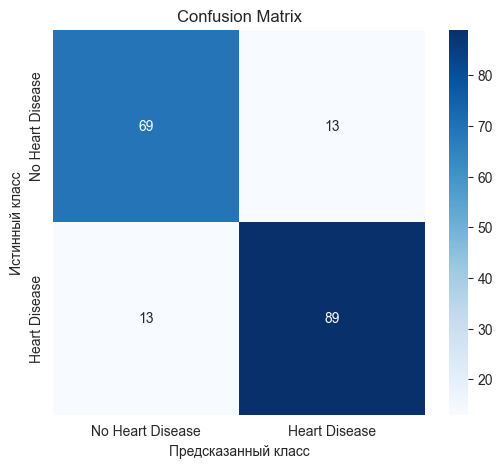

In [117]:
best_knn = grid_search.best_estimator_
best_knn.fit(X_train, y_train)
y_pred = best_knn.predict(X_test)

acc = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, best_knn.predict_proba(X_test)[:, 1])
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Улучшенный KNN (k=17):")
print(f"Accuracy: {acc:.4f}")
print(f"ROC-AUC:  {roc_auc:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Recall:   {recall:.4f}")

conf_matrix(y_pred, y_test)

Видно, что модель работает лучше. Она лучше распознает больных. Recall дает понять что она пропускает только 13% больных, что лучше 17% в начальном бейзлайне.

### Ручная реализация

Проводим препроцессинг данных

In [118]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("Форма обработанных данных:", X_train_processed.shape)

Форма обработанных данных: (734, 15)


Сама реализация

In [119]:
class KNNClassifier:
    def __init__(self, n_neighbors=5, weights='uniform', metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.metric = metric

    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y)
        return self

    def _euclidean_distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2) ** 2))

    def _predict_single(self, x):
        distances = np.array([
            self._euclidean_distance(x, x_train) for x_train in self.X_train
        ])

        k_neighbor_indices = np.argsort(distances)[:self.n_neighbors]
        k_neighbor_labels = self.y_train[k_neighbor_indices]

        if self.weights == 'uniform':
            most_common = Counter(k_neighbor_labels).most_common(1)[0][0]
            return most_common

        elif self.weights == 'distance':
            k_distances = distances[k_neighbor_indices]
            k_distances = np.where(k_distances == 0, 1e-10, k_distances)
            weights = 1 / k_distances
            class_weights = {}
            for label, weight in zip(k_neighbor_labels, weights):
                class_weights[label] = class_weights.get(label, 0) + weight
            return max(class_weights, key=class_weights.get)

    def predict(self, X):
        X = np.array(X)
        return np.array([self._predict_single(x) for x in X])

    def predict_proba(self, X):
        X = np.array(X)
        probabilities = []
        for x in X:
            distances = np.array([
                self._euclidean_distance(x, x_train) for x_train in self.X_train
            ])
            k_neighbor_indices = np.argsort(distances)[:self.n_neighbors]
            k_neighbor_labels = self.y_train[k_neighbor_indices]

            if self.weights == 'uniform':
                prob_class_1 = np.mean(k_neighbor_labels)
            else:
                k_distances = distances[k_neighbor_indices]
                k_distances = np.where(k_distances == 0, 1e-10, k_distances)
                weights = 1 / k_distances
                prob_class_1 = np.sum(weights[k_neighbor_labels == 1]) / np.sum(weights)

            probabilities.append([1 - prob_class_1, prob_class_1])
        return np.array(probabilities)

Используем те же параметры, что в бейзлайне: k=5, uniform, euclidean. После чего применим найденные лучшие параметры

Ручная реализация KNN (k=5):
Accuracy: 0.8533
ROC-AUC:  0.9194
F1-score: 0.8629
Recall:   0.8333


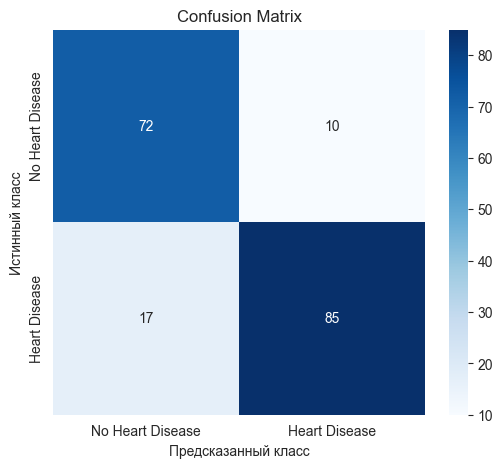


Улучшенная ручная KNN (k=17, weights='distance', metric='manhattan'):
Accuracy: 0.8478
ROC-AUC:  0.9258
F1-score: 0.8627
Recall:   0.8627


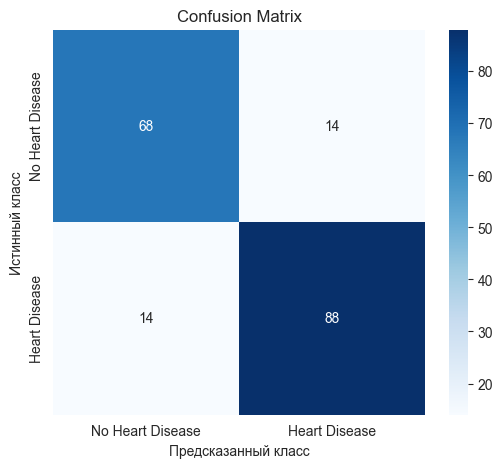

In [120]:
my_knn = KNNClassifier(n_neighbors=5, weights='uniform')
my_knn.fit(X_train_processed, y_train)

y_pred_my = my_knn.predict(X_test_processed)
y_proba_my = my_knn.predict_proba(X_test_processed)[:, 1]

acc_my = accuracy_score(y_test, y_pred_my)
roc_auc_my = roc_auc_score(y_test, y_proba_my)
f1_my = f1_score(y_test, y_pred_my)
recall_my = recall_score(y_test, y_pred_my)

print("Ручная реализация KNN (k=5):")
print(f"Accuracy: {acc_my:.4f}")
print(f"ROC-AUC:  {roc_auc_my:.4f}")
print(f"F1-score: {f1_my:.4f}")
print(f"Recall:   {recall_my:.4f}")

conf_matrix(y_pred_my, y_test)


my_knn_best = KNNClassifier(n_neighbors=best_params['classifier__n_neighbors'], weights=best_params['classifier__weights'], metric=best_params['classifier__metric'])
my_knn_best.fit(X_train_processed, y_train)

y_pred_best = my_knn_best.predict(X_test_processed)
y_proba_best = my_knn_best.predict_proba(X_test_processed)[:, 1]

acc_best = accuracy_score(y_test, y_pred_best)
roc_auc_best = roc_auc_score(y_test, y_proba_best)
f1_best = f1_score(y_test, y_pred_best)
recall_best = recall_score(y_test, y_pred_best)

print(f"\nУлучшенная ручная KNN (k={best_params['classifier__n_neighbors']}, weights='{best_params['classifier__weights']}', metric='{best_params['classifier__metric']}'):")
print(f"Accuracy: {acc_best:.4f}")
print(f"ROC-AUC:  {roc_auc_best:.4f}")
print(f"F1-score: {f1_best:.4f}")
print(f"Recall:   {recall_best:.4f}")

conf_matrix(y_pred_best, y_test)

Снова мы видим улучшения. Есть падения метрик, но это объясняется тем, что модель начала немного жертвовать здоровыми, чтобы не пропустить больных. \
Модель стала "чувствительнее" к болезни: \
+3 больных пациента найдено (TP+), \
–3 больных пропущено (FN-). \
Но "пожертвовала" здоровыми: \
+4 ложных тревоги (FP+), \
–4 здоровых пациента ошибочно названы больными (TN-). \
Повышение Recall и ROC-AUC особенно важно в медицинских задачах.

# Регрессия

Датасет представляет собой данные о студентах и факторах, которые могут повлиять на их рейтинг на экзамене. Задача состоит в том, чтобы предугадать их оценки на на экзамене. \
Задача имеет гуманитарный, психологический характер. Целевая переменная зависит от субъективных параметров, что может увеличить ошибку.

In [121]:
df_reg = kagglehub.dataset_load(KaggleDatasetAdapter.PANDAS,
                                  "kundanbedmutha/exam-score-prediction-dataset",
                                  "Exam_Score_Prediction.csv")
df_reg.head()

,student_id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,1,17,male,diploma,2.78,92.9,yes,7.4,poor,coaching,low,hard,58.9
1,2,23,other,bca,3.37,64.8,yes,4.6,average,online videos,medium,moderate,54.8
2,3,22,male,b.sc,7.88,76.8,yes,8.5,poor,coaching,high,moderate,90.3
3,4,20,other,diploma,0.67,48.4,yes,5.8,average,online videos,low,moderate,29.7
4,5,20,female,diploma,0.89,71.6,yes,9.8,poor,coaching,low,moderate,43.7


Проверка на пропуски

In [122]:
df_reg = df_reg.drop('student_id', axis=1)

print("\nФорма:", df_reg.shape)
print("\nПропуски:")
print(df_reg.isnull().sum())


Форма: (20000, 12)

Пропуски:
age                 0
gender              0
course              0
study_hours         0
class_attendance    0
internet_access     0
sleep_hours         0
sleep_quality       0
study_method        0
facility_rating     0
exam_difficulty     0
exam_score          0
dtype: int64


Обработка категориальных признаков

In [123]:
df_reg['internet_access'] = df_reg['internet_access'].map({'yes': 1, 'no': 0})

sleep_map = {'poor': 0, 'average': 1, 'good': 2}
exam_diff_map = {'easy': 0, 'moderate': 1, 'hard': 2}
facil_diff_map = {'low': 0, 'medium': 1, 'high': 2}

df_reg['sleep_quality'] = df_reg['sleep_quality'].map(sleep_map)
df_reg['exam_difficulty'] = df_reg['exam_difficulty'].map(exam_diff_map)
df_reg['facility_rating'] = df_reg['facility_rating'].map(facil_diff_map)

print("NaN после маппинга:")
print(df_reg[['sleep_quality', 'exam_difficulty', 'facility_rating']].isnull().sum())

NaN после маппинга:
sleep_quality      0
exam_difficulty    0
facility_rating    0
dtype: int64


Визуализация распределения целевой переменной.

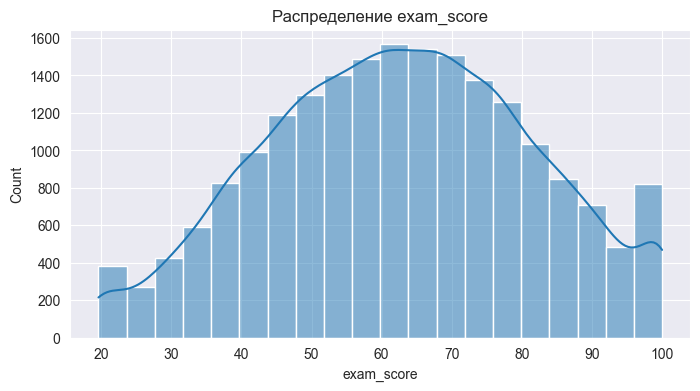

Статистика exam_score:
count    20000.000000
mean        62.513225
std         18.908491
min         19.599000
25%         48.800000
50%         62.600000
75%         76.300000
max        100.000000
Name: exam_score, dtype: float64


In [124]:
plt.figure(figsize=(8, 4))
sns.histplot(df_reg['exam_score'], kde=True, bins=20)
plt.title('Распределение exam_score')
plt.show()

print("Статистика exam_score:")
print(df_reg['exam_score'].describe())

Как видим распределение похоже на нормальное, но имеет накопления по краям, что логично. Среди студентов много отличников и тех кто полностью проваливает экзамен (бимодальное распределение). \
Запустим модель от sklearn.

In [125]:
X = df_reg.drop('exam_score', axis=1)
y = df_reg['exam_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numerical_features = ['age', 'study_hours', 'class_attendance', 'sleep_hours']
binary_features = ['internet_access']
ordinal_features = ['sleep_quality', 'exam_difficulty', 'facility_rating']
categorical_features = ['gender', 'course', 'study_method']

preprocessor_reg = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('ord', 'passthrough', ordinal_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ],
    remainder='passthrough'
)

knn_reg_baseline = Pipeline(steps=[
    ('preprocessor', preprocessor_reg),
    ('regressor', KNeighborsRegressor(n_neighbors=5))
])

knn_reg_baseline.fit(X_train, y_train)
y_pred_baseline = knn_reg_baseline.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_baseline))
mae = mean_absolute_error(y_test, y_pred_baseline)
r2 = r2_score(y_test, y_pred_baseline)

print(f"Бейзлайн KNNRegressor (k=5):")
print(f"RMSE: {rmse:.2f}")
print(f"MAE:  {mae:.2f}")
print(f"R²:   {r2:.4f}")

Бейзлайн KNNRegressor (k=5):
RMSE: 11.64
MAE:  9.36
R²:   0.6211


RMSE = 11.64. Разница между RMSE и MAE говорит о том, что некоторые предсказания сильно отклоняются. Это согласуется с наблюдениями, много студентов с крайними оценками (0–20 и 80–100), и KNN может плохо обобщать на них, особенно если соседи из "среднего" сегмента. \
MAE = 9.36. Для студента с реальным баллом 70, модель может предсказать от 60 до 80 - приемлемо, но не идеально. \
R² = 0.62, это неплохо. Модель объясняет 62% дисперсии, что нормально для гуманитарных задач. \
Теперь найдем лучшие параметры.

In [126]:
param_grid = {
    'regressor__n_neighbors': range(3, 21, 2),
    'regressor__weights': ['uniform', 'distance']
}

grid_reg = GridSearchCV(
    knn_reg_baseline,
    param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_reg.fit(X_train, y_train)
print("Лучшие параметры:", grid_reg.best_params_)
print("Лучший RMSE (CV):", -grid_reg.best_score_)

Лучшие параметры: {'regressor__n_neighbors': 19, 'regressor__weights': 'distance'}
Лучший RMSE (CV): 10.889487250260064


Протестируем на тестовых данных

In [127]:
best_model = grid_reg.best_estimator_

y_pred_best = best_model.predict(X_test)

rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
mae_best = mean_absolute_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print("Улучшенная модель (на тестовой выборке):")
print(f"RMSE: {rmse_best:.2f}")
print(f"MAE:  {mae_best:.2f}")
print(f"R²:   {r2_best:.4f}")

Улучшенная модель (на тестовой выборке):
RMSE: 10.79
MAE:  8.73
R²:   0.6747


RMSE снизился с 11.64 до 10.79. модель стала надёжнее при предсказании как отличников, так и двоечников - особенно важно, учитывая скопление оценок на краях. \
MAE снизился с 9.36 до 8.73. Для студента с реальным баллом 65, предсказание будет в диапазоне 56–74, уже достаточно точно для образовательной аналитики. \
R² вырос с 0.62 до 0.67. Модель теперь объясняет на 5.4% больше дисперсии. Это заметный прирост для регрессионной задачи в социальных науках. \


### Ручная реализация

In [128]:
class KNNRegressor:
    def __init__(self, n_neighbors=5, weights='uniform', metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.metric = metric

    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y)
        return self

    def _euclidean_distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2) ** 2))

    def _predict_single(self, x):
        distances = np.sqrt(np.sum((self.X_train - x) ** 2, axis=1))
        k_neighbor_indices = np.argsort(distances)[:self.n_neighbors]
        k_neighbor_targets = self.y_train[k_neighbor_indices]

        if self.weights == 'uniform':
            return np.mean(k_neighbor_targets)
        elif self.weights == 'distance':
            k_distances = distances[k_neighbor_indices]
            k_distances = np.where(k_distances == 0, 1e-10, k_distances)
            weights = 1.0 / k_distances
            return np.average(k_neighbor_targets, weights=weights)

    def predict(self, X):
        X = np.array(X)
        return np.array([self._predict_single(x) for x in X])

Запускаем на начальном бейзлайне

In [129]:
X_train_processed = preprocessor_reg.fit_transform(X_train)
X_test_processed = preprocessor_reg.transform(X_test)

my_knn_reg = KNNRegressor()
my_knn_reg.fit(X_train_processed, y_train)

y_pred_my_reg = my_knn_reg.predict(X_test_processed)

rmse_my = np.sqrt(mean_squared_error(y_test, y_pred_my_reg))
mae_my = mean_absolute_error(y_test, y_pred_my_reg)
r2_my = r2_score(y_test, y_pred_my_reg)

print("Ручная реализация KNNRegressor:")
print(f"RMSE: {rmse_my:.2f}")
print(f"MAE:  {mae_my:.2f}")
print(f"R²:   {r2_my:.4f}")

Ручная реализация KNNRegressor:
RMSE: 11.64
MAE:  9.36
R²:   0.6211


In [130]:
best_k = grid_reg.best_params_['regressor__n_neighbors']
best_weights = grid_reg.best_params_['regressor__weights']

my_knn_reg = KNNRegressor(n_neighbors=best_k, weights=best_weights)
my_knn_reg.fit(X_train_processed, y_train)

y_pred_my_reg = my_knn_reg.predict(X_test_processed)

rmse_my = np.sqrt(mean_squared_error(y_test, y_pred_my_reg))
mae_my = mean_absolute_error(y_test, y_pred_my_reg)
r2_my = r2_score(y_test, y_pred_my_reg)

print("Улучшенная ручная реализация KNNRegressor:")
print(f"RMSE: {rmse_my:.2f}")
print(f"MAE:  {mae_my:.2f}")
print(f"R²:   {r2_my:.4f}")

Улучшенная ручная реализация KNNRegressor:
RMSE: 10.79
MAE:  8.73
R²:   0.6747


Мы видим идентичные результаты с моделью sklearn, что говорит о правильной реализации.